In [149]:
# Import required packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skimage.io import imread
from skimage.transform import resize
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import random
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn as nn
import torch.nn.init as init

ModuleNotFoundError: No module named 'prettytable'

In [2]:
# Import image data, including flattening the images and converting them to an array
    # (Without masks)
#normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
#covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
#images = []
#labels = []
#for image in os.listdir(normal_folder_path):
#    image_path = os.path.join(normal_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(0)
#for image in os.listdir(covid_folder_path):
#    image_path = os.path.join(covid_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(1)
#X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [3]:
# Import image data, including flattening the images and converting them to an array
    # (With masks)
normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
normal_mask_path = 'COVID-19_Radiography_Dataset/Normal/masks'
covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
covid_mask_path = 'COVID-19_Radiography_Dataset/COVID/masks'
images = []
labels = []
for image in os.listdir(normal_folder_path):
    image_path = os.path.join(normal_folder_path, image)
    mask_path = os.path.join(normal_mask_path, image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(0)
for image in os.listdir(covid_folder_path):
    image_path = os.path.join(covid_folder_path, image)
    mask_path = os.path.join(covid_mask_path,image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(1)
X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [54]:
# Split the data into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2024) # test set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.18, random_state=2024) # validation set

In [55]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [56]:
# Create PCA sets for reduced dimension models
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [57]:
# Convert to tensors for PyTorch training
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)
X_val_scaled_tensor = torch.tensor(X_val_scaled, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val ,dtype = torch.float32)

X_train_tensor_pca = torch.tensor(X_train_pca, dtype = torch.float32)
X_test_tensor_pca = torch.tensor(X_test_pca, dtype = torch.float32)
X_val_tensor_pca = torch.tensor(X_val_pca, dtype = torch.float32)

In [139]:
# Define a direct MLP model
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class DirectMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 512),
            nn.ReLU(),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class DropoutMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class PCA_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class PCA_ExtraParam_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)   

In [61]:
# Create function to test each model
def test_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Forward pass: compute predictions
            outputs = model(inputs)
            
            # Since our output is a single probability (binary classification), 
            # apply threshold to classify
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            
            # Collect predictions and labels for F1-score
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy for compatibility
            all_predictions.extend(predicted.cpu().numpy())
            
            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / total
    
    # Calculate precision, recall, and F1
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return accuracy, precision, recall, f1

In [60]:
test_dataset = TensorDataset(X_test_scaled_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

**Train Logistic Regression Model**

In [ ]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 20  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
LR_model = LogisticRegression()
optimizer = torch.optim.Adam(LR_model.parameters(), lr=0.001)
num_epochs = 300

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    LR_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = LR_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    LR_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = LR_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

In [ ]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue')
plt.plot(range(1, graph_param),val_losses,color = 'red')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue')
plt.plot(range(1, graph_param),val_accuracies,color = 'red')

In [ ]:
LR_train_evaluation = test_model(LR_model,train_dataloader)
LR_val_evaluation = test_model(LR_model,val_dataloader)
LR_test_evaluation = test_model(LR_model,test_dataloader)
LR_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": LR_train_evaluation,
    "Validation": LR_val_evaluation,
    "Test": LR_test_evaluation,
}
LR_evaluation = pd.DataFrame(LR_evaluation)
LR_evaluation

**Train MLP Model**

In [ ]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
MLP_model = DirectMLP()
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
num_epochs = 80

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    MLP_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = MLP_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    MLP_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = MLP_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

In [ ]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue')
plt.plot(range(1, graph_param),val_losses,color = 'red')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue')
plt.plot(range(1, graph_param),val_accuracies,color = 'red')

In [ ]:
MLP_train_evaluation = test_model(MLP_model,train_dataloader)
MLP_val_evaluation = test_model(MLP_model,val_dataloader)
MLP_test_evaluation = test_model(MLP_model,test_dataloader)
MLP_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": MLP_train_evaluation,
    "Validation": MLP_val_evaluation,
    "Test": MLP_test_evaluation,
}
MLP_evaluation = pd.DataFrame(MLP_evaluation)
MLP_evaluation

**Train Dropout Model**

In [146]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Early stopping parameters
patience = 4  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
Dropout_model = DropoutMLP()
optimizer = torch.optim.Adam(Dropout_model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    Dropout_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = Dropout_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    Dropout_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = Dropout_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/100], Train Loss: 0.6962, Val Accuracy: 0.7523
Epoch [2/100], Train Loss: 0.5044, Val Accuracy: 0.7841
Epoch [3/100], Train Loss: 0.4585, Val Accuracy: 0.8064
Epoch [4/100], Train Loss: 0.4260, Val Accuracy: 0.8212
Epoch [5/100], Train Loss: 0.3939, Val Accuracy: 0.8221
Epoch [6/100], Train Loss: 0.3804, Val Accuracy: 0.8163
Patience Counter: 1/20
Epoch [7/100], Train Loss: 0.3619, Val Accuracy: 0.8176
Patience Counter: 2/20
Epoch [8/100], Train Loss: 0.3455, Val Accuracy: 0.8149
Patience Counter: 3/20
Epoch [9/100], Train Loss: 0.3250, Val Accuracy: 0.8306
Patience Counter: 4/20
Epoch [10/100], Train Loss: 0.3106, Val Accuracy: 0.8324
Patience Counter: 5/20
Epoch [11/100], Train Loss: 0.2982, Val Accuracy: 0.8382
Patience Counter: 6/20
Epoch [12/100], Train Loss: 0.2795, Val Accuracy: 0.8342
Patience Counter: 7/20
Epoch [13/100], Train Loss: 0.2729, Val Accuracy: 0.8283
Patience Counter: 8/20
Epoch [14/100], Train Loss: 0.2548, Val Accuracy: 0.8288
Patience Counter: 9/20


KeyboardInterrupt: 

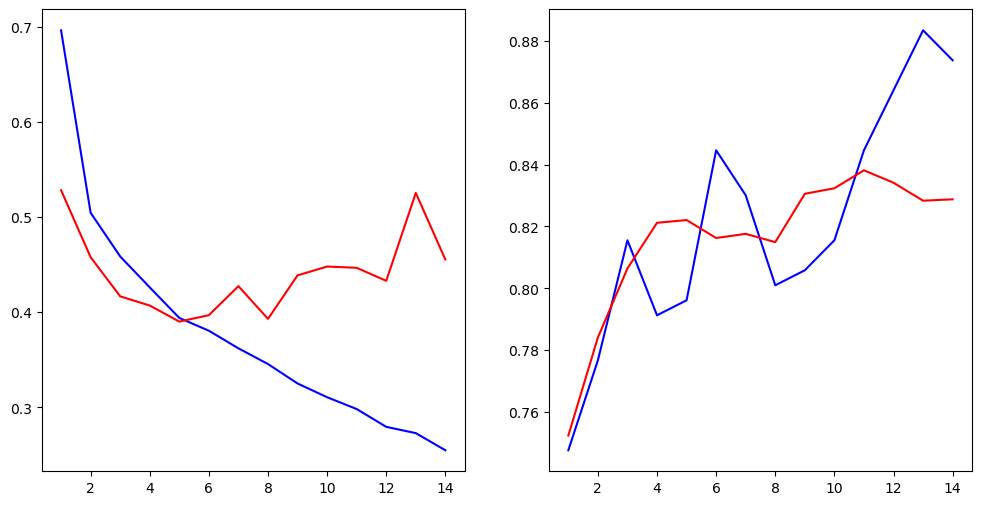

In [156]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue')
plt.plot(range(1, graph_param),val_losses,color = 'red')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue')
plt.plot(range(1, graph_param),val_accuracies,color = 'red')

In [151]:
Dropout_train_evaluation = test_model(Dropout_model,train_dataloader)
Dropout_val_evaluation = test_model(Dropout_model,val_dataloader)
Dropout_test_evaluation = test_model(Dropout_model,test_dataloader)
Dropout_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": Dropout_train_evaluation,
    "Validation": Dropout_val_evaluation,
    "Test": Dropout_test_evaluation,
}
Dropout_evaluation = pd.DataFrame(Dropout_evaluation)
Dropout_evaluation

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'], 'Train': (0.9114818449460255, 0.8338334583645911, 0.8288590604026845, 0.8313388182498129), 'Validation': (0.8270004470272687, 0.675392670157068, 0.6581632653061225, 0.6666666666666666), 'Test': (0.8196958725561188, 0.6430678466076696, 0.630057803468208, 0.6364963503649635)}


**Train PCA Reduced Model**

In [ ]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Early stopping parameters
patience = 20  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCA_model = PCA_MLP()
optimizer = torch.optim.Adam(PCA_model.parameters(), lr=0.001)
num_epochs = 150

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCA_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCA_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCA_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCA_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

In [ ]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue')
plt.plot(range(1, graph_param),val_losses,color = 'red')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue')
plt.plot(range(1, graph_param),val_accuracies,color = 'red')

In [ ]:
test_dataset = TensorDataset(X_test_tensor_pca, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

In [ ]:
PCA_train_evaluation = test_model(PCA_model,train_dataloader)
PCA_val_evaluation = test_model(PCA_model,val_dataloader)
PCA_test_evaluation = test_model(PCA_model,test_dataloader)
PCA_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCA_train_evaluation,
    "Validation": PCA_val_evaluation,
    "Test": PCA_test_evaluation,
}
PCA_evaluation = pd.DataFrame(PCA_evaluation)
PCA_evaluation

**Train PCA Model with Extra Parameters**

In [ ]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 8  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCAX_model = PCA_ExtraParam_MLP()
optimizer = torch.optim.Adam(PCAX_model.parameters(), lr=0.001)
num_epochs = 75

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCAX_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCAX_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCAX_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCAX_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

In [ ]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue')
plt.plot(range(1, graph_param),val_losses,color = 'red')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue')
plt.plot(range(1, graph_param),val_accuracies,color = 'red')

In [ ]:
PCAX_train_evaluation = test_model(PCA_model,train_dataloader)
PCAX_val_evaluation = test_model(PCA_model,val_dataloader)
PCAX_test_evaluation = test_model(PCA_model,test_dataloader)
PCAX_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCAX_train_evaluation,
    "Validation": PCAX_val_evaluation,
    "Test": PCAX_test_evaluation,
}
PCAX_evaluation = pd.DataFrame(PCAX_evaluation)
PCAX_evaluation

## EVERYTHING BELOW HERE IS OLD CODE AND SHOULD BE IGNORED FOR NOW (LEFT UNTIL I KNOW THE NEW CODE IS GOOD)

**TRAINING THE LOGISTIC MODEL**

In [38]:
# Train the model (only 1 epoch and it took 30 minutes yikes)
dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

loss_function = nn.BCELoss()
model = Logistic()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 100
train_MSE = []

for epoch in range(num_epochs):
    counter = 0
    epoch_loss = 0
    batch_count = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        counter += 1
        print(counter)
        epoch_loss += loss.item()
        batch_count += 1
    train_MSE.append(epoch_loss/batch_count)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [7/100], Loss: 0.3851
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86

279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [13/100], Loss: 0.8895
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293

146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [26/100], Loss: 0.0017
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59

285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [32/100], Loss: 0.0001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208

94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
34

213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [45/100], Loss: 0.0004
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136

316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [51/100], Loss: 1.3382
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239

108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [58/100], Loss: 0.0109
1
2
3
4
5
6
7
8

279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [64/100], Loss: 0.1082
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202

115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [71/100], Loss: 0.0004
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
1

207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [77/100], Loss: 0.0001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130

337
338
339
340
341
342
343
344
345
346
Epoch [83/100], Loss: 0.0075
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [90/100], Loss: 0.0004
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [96/100], Loss: 16.6667
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
14

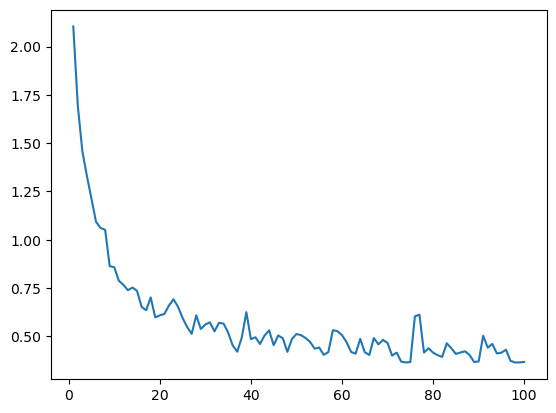

In [39]:
# Graph the error on each batch in the epoch I trained
len(train_MSE)
plt.plot(range(1, num_epochs+1),train_MSE)

In [40]:
test_model(model, test_dataloader)
test_model(model, dataloader)

Test Accuracy: 71.43%
F1-Score: 0.51
Test Accuracy: 95.42%
F1-Score: 0.92


**ANOTHER MODEL**

In [46]:
# Train the model (only 1 epoch and it took 30 minutes yikes)
dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

loss_function = nn.BCELoss()
model = Kaggle()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
train_MSE = []

for epoch in range(num_epochs):
    counter = 0
    epoch_loss = 0
    batch_count = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        counter += 1
        print(counter)
        epoch_loss += loss.item()
        batch_count += 1
    train_MSE.append(epoch_loss/batch_count)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [7/20], Loss: 1.5233
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
2

216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [13/20], Loss: 0.0816
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Epoch [19/20], Loss: 0.0062
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231


Test Accuracy: 80.67%
F1-Score: 0.63
Test Accuracy: 95.37%
F1-Score: 0.92


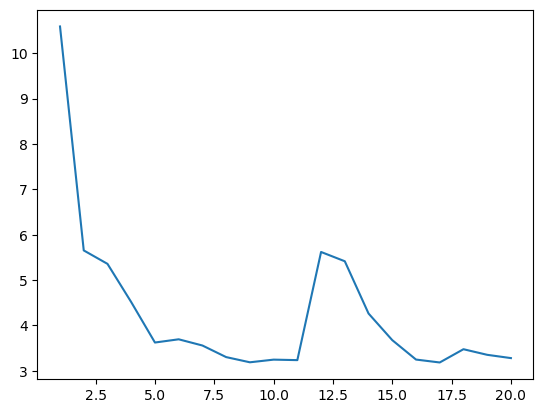

In [47]:
# Graph the error on each batch in the epoch I trained
len(train_MSE)
plt.plot(range(1, num_epochs+1),train_MSE)
test_model(model, test_dataloader)
test_model(model, dataloader)

**DROPOUT MODEL**

In [49]:
# Train the model (only 1 epoch and it took 30 minutes yikes)
dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

loss_function = nn.BCELoss()
model = Dropout()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
train_MSE = []

for epoch in range(num_epochs):
    counter = 0
    epoch_loss = 0
    batch_count = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        counter += 1
        print(counter)
        epoch_loss += loss.item()
        batch_count += 1
    train_MSE.append(epoch_loss/batch_count)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

1
2
3
4
5
6
7
8
9
10
11
12
Epoch [1/20], Loss: 0.4944
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [2/20], Loss: 0.6089
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [3/20], Loss: 0.5664
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [4/20], Loss: 0.3775
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [5/20], Loss: 0.3035
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [6/20], Loss: 0.3938
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [7/20], Loss: 0.4384
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [8/20], Loss: 0.4156
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [9/20], Loss: 0.4468
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [10/20], Loss: 0.3658
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [11/20], Loss: 0.3007
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [12/20], Loss: 0.3018
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [13/20], Loss: 0.3615
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [14/20], Loss: 0.1789
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [15/20], Loss: 0.4850
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [16/20], Loss: 0.3386
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [17/20], Loss: 0.3581
1
2
3
4
5
6
7
8
9
10
11
12
Epoch [18/20], Loss: 0.2829
1
2
3
4
5
6
7
8
9
1

Test Accuracy: 83.45%
F1-Score: 0.64
Test Accuracy: 89.91%
F1-Score: 0.79


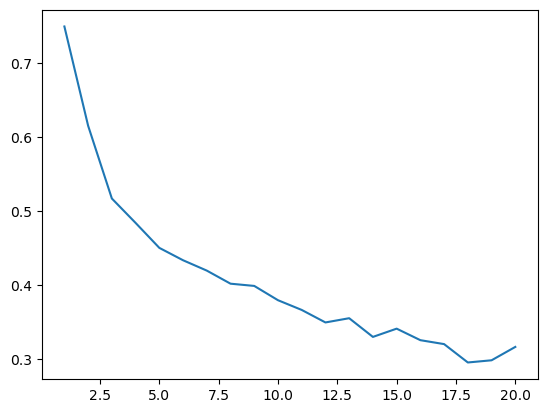

In [50]:
# Graph the error on each batch in the epoch I trained
len(train_MSE)
plt.plot(range(1, num_epochs+1),train_MSE)
test_model(model, test_dataloader)
test_model(model, dataloader)

In [ ]:
## This was just so I can remember these commands for later, you can ignore them
np.set_printoptions(threshold=np.inf)
np.set_printoptions()